In [1]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

In [2]:
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of edges: {data.num_edges}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}') # nodes not connected by edges
print(f'Graph has loops: {data.has_self_loops()}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Dataset: CiteSeer()
---------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Number of edges: 9104
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False
Average node degree: 2.74


In [4]:
print(data.train_mask.sum().item()) # train_mask denotes against which nodes to train (140 nodes)
print(data.val_mask.sum().item()) # val_mask denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes)
print(data.test_mask.sum().item()) # test_mask denotes against which nodes to test (1000 nodes).

120
500
1000


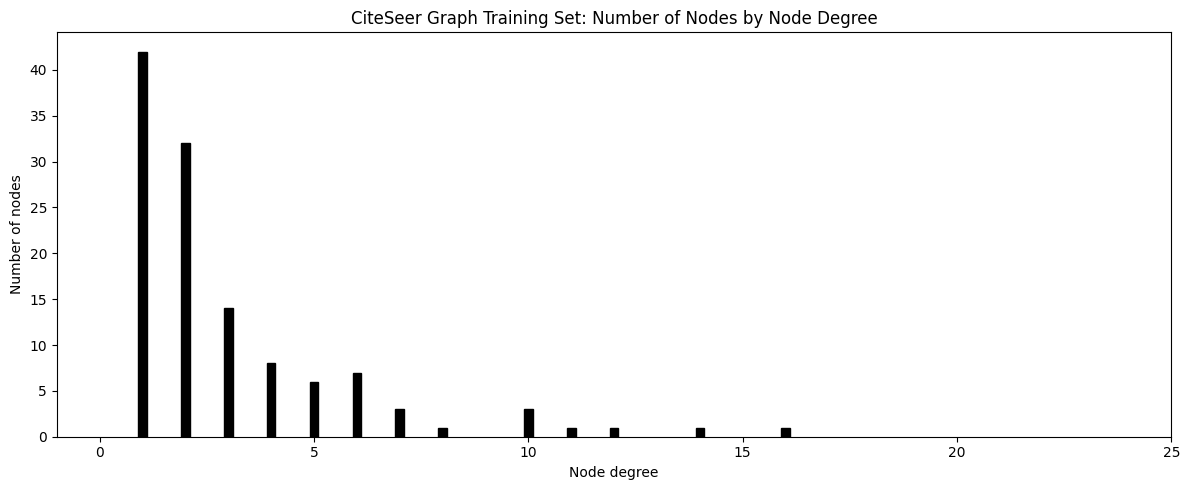

Counter({1.0: 42, 2.0: 32, 3.0: 14, 4.0: 8, 6.0: 7, 5.0: 6, 10.0: 3, 7.0: 3, 12.0: 1, 14.0: 1, 11.0: 1, 8.0: 1, 16.0: 1})


In [26]:
#Plot the number of nodes per node degree
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()
# Select degrees of nodes in test set
degrees=degrees[data.train_mask.numpy()]

numbers = Counter(degrees)

fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_xlim([-1, 25])
plt.bar(numbers.keys(), numbers.values(),width=0.2, color='black', edgecolor='black')
plt.title('CiteSeer Graph Training Set: Number of Nodes by Node Degree')
plt.tight_layout()
plt.savefig('CiteSeer_Graph_Train_Node_Degrees.png')

plt.show()

print(numbers)

In [2]:
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.optim as optim
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import random
random.seed(0)

torch.manual_seed(0)

class GAT(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, num_heads, heads_p_dropout,size_gat, p_dropout):
        super(GAT, self).__init__()
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(GATv2Conv(num_features, hidden_channels, heads=num_heads,dropout=heads_p_dropout))

        for i in range(size_gat):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))

        #add dropout layer
        self.dropout = nn.Dropout(p=p_dropout)

        # Output layer
        self.convs.append(GATv2Conv(hidden_channels*num_heads, num_classes, heads=1))   # concat=False means that the 
                                                                                    # multihead attentions are averaged
        self.act = F.leaky_relu
        #self.act = F.elu
        
    # Model with leading dropout
    # def forward(self, x, edge_index):
    #     for conv in self.convs:
    #         x = self.dropout(x)
    #         x = conv(x, edge_index)

    #         if conv != self.convs[-1]:
    #             x = self.act(x)

    #     return F.softmax(x, dim=1)

    # Model w/o leading dropout
    def forward(self, x, edge_index):
        for conv in self.convs:
            if conv == self.convs[0]:
                x = conv(x, edge_index)
                x = self.act(x)
            elif conv in self.convs[1:-2]:
                x = self.dropout(x)
                x = conv(x, edge_index)
                x = self.act(x)
            else:
                x = self.dropout(x)
                x = conv(x, edge_index)

        return F.softmax(x, dim=1)

In [ ]:
import optuna
from optuna.pruners import SuccessiveHalvingPruner, NopPruner
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
import numpy as np

n_trails = 50
n_jobs = 5 # Number of parallel jobs

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [8,16,32,64,128,256]) #try [16,32,64,128,256]
    size_gat = trial.suggest_categorical('hidden_layers', [0,1,2])
    p_dropout = trial.suggest_float('p_dropout', 0.4, 0.7)
    batch_size=trial.suggest_categorical('batch_size', [120]) # entire training set / batch training
    epochs = trial.suggest_categorical('epochs', np.arange(10,130,10).tolist())
    #optimizer = trial.suggest_categorical('optimizer', [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam])
    optimizer = trial.suggest_categorical('optimizer', [Adam])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    num_heads = trial.suggest_categorical('num_heads', [4,8,16])
    heads_p_dropout = trial.suggest_float('heads_p_dropout', 0.1, 0.7)
    
    data = dataset[0]
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    #(self, num_features, num_classes, hidden_channels, dropout, num_heads, size_gat)
    model = GAT(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, 
                num_heads=num_heads, heads_p_dropout=heads_p_dropout,size_gat=size_gat, p_dropout=p_dropout)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=0.9) #for RMSprop

    for epoch in range(1, epochs+1):
        for data in loader:
            criterion=nn.CrossEntropyLoss()
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            trial.report(loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Validate model
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Only consider validation data
    true_labels = data.y[data.val_mask].cpu().numpy()
    predicted_labels = pred[data.val_mask].cpu().numpy()

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average

    # Acuracy
    correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc = correct / data.val_mask.sum().item()
    print(f'Validation Accuracy: {acc * 100:.2f}%')
    
    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GAT_CiteSeer_test_results04.csv', 'a') as f:
        optimizer_name=optimizer.__class__.__name__
        f.write(f'{batch_size}, {hidden_channels}, {num_heads},{size_gat},{heads_p_dropout},{lr}, {weight_decay}, {epochs}, {p_dropout}, {optimizer_name},{recall},{acc},{f1}\n')
    
    return acc

study = optuna.create_study(direction="maximize", pruner=NopPruner())
#study = optuna.create_study(direction="minimize", pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=4, min_early_stopping_rate=0))
study.optimize(objective, n_trials=n_trails, timeout=6000, n_jobs=n_jobs,show_progress_bar = True)
print(study.best_trial)

[I 2023-12-01 20:44:25,569] A new study created in memory with name: no-name-5e44824e-0873-44d6-bcde-fe05b8482650
C:\Users\ramme\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.40%
[I 2023-12-01 20:44:49,983] Trial 4 finished with value: 0.674 and parameters: {'lr': 0.0008255194936040153, 'hidden_channels': 128, 'hidden_layers': 0, 'p_dropout': 0.44004085538312776, 'batch_size': 120, 'epochs': 20, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.008149783263609316, 'num_heads': 8, 'heads_p_dropout': 0.6827807493888969}. Best is trial 4 with value: 0.674.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 20.80%
[I 2023-12-01 20:44:57,377] Trial 2 finished with value: 0.208 and parameters: {'lr': 2.2367494704753766e-05, 'hidden_channels': 16, 'hidden_layers': 2, 'p_dropout': 0.43003418225525236, 'batch_size': 120, 'epochs': 20, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.0004621025782066569, 'num_heads': 4, 'heads_p_dropout': 0.3656550449033904}. Best is trial 4 with value: 0.674.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.60%
[I 2023-12-01 20:45:17,971] Trial 0 finished with value: 0.686 and parameters: {'lr': 0.0006398850928752537, 'hidden_channels': 64, 'hidden_layers': 1, 'p_dropout': 0.46254449998395736, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.005196645535238667, 'num_heads': 8, 'heads_p_dropout': 0.3966648139367194}. Best is trial 0 with value: 0.686.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.60%
[I 2023-12-01 20:45:55,071] Trial 6 finished with value: 0.716 and parameters: {'lr': 0.0009369256835633683, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.6683790270674775, 'batch_size': 120, 'epochs': 20, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.006856890501945798, 'num_heads': 8, 'heads_p_dropout': 0.24657433110419708}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.80%
[I 2023-12-01 20:46:52,894] Trial 3 finished with value: 0.698 and parameters: {'lr': 0.0008301907200198501, 'hidden_channels': 32, 'hidden_layers': 2, 'p_dropout': 0.627007903808189, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.008544333392144339, 'num_heads': 4, 'heads_p_dropout': 0.18254772923443308}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.00%
[I 2023-12-01 20:47:19,092] Trial 7 finished with value: 0.67 and parameters: {'lr': 0.009060717194395539, 'hidden_channels': 16, 'hidden_layers': 2, 'p_dropout': 0.560731017260319, 'batch_size': 120, 'epochs': 50, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.002790421779504028, 'num_heads': 16, 'heads_p_dropout': 0.36765034438347033}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 45.60%
[I 2023-12-01 20:47:57,544] Trial 1 finished with value: 0.456 and parameters: {'lr': 4.563594039978948e-05, 'hidden_channels': 128, 'hidden_layers': 1, 'p_dropout': 0.46060558350211717, 'batch_size': 120, 'epochs': 40, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.00554206302609316, 'num_heads': 16, 'heads_p_dropout': 0.6532241687562172}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.20%
[I 2023-12-01 20:49:06,262] Trial 9 finished with value: 0.672 and parameters: {'lr': 0.0016573150265171436, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.4356716273698597, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.002032070312573646, 'num_heads': 4, 'heads_p_dropout': 0.29397643895544046}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 55.40%
[I 2023-12-01 20:49:33,081] Trial 10 finished with value: 0.554 and parameters: {'lr': 0.0001522557734360913, 'hidden_channels': 64, 'hidden_layers': 2, 'p_dropout': 0.5633293646615928, 'batch_size': 120, 'epochs': 30, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.006752840645960043, 'num_heads': 16, 'heads_p_dropout': 0.3871533918920742}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 64.20%
[I 2023-12-01 20:50:26,661] Trial 11 finished with value: 0.642 and parameters: {'lr': 0.00010073184521845882, 'hidden_channels': 16, 'hidden_layers': 1, 'p_dropout': 0.6564977857214755, 'batch_size': 120, 'epochs': 70, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 8.034012522719402e-05, 'num_heads': 16, 'heads_p_dropout': 0.38568891185238763}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 46.80%
[I 2023-12-01 20:51:00,099] Trial 5 finished with value: 0.468 and parameters: {'lr': 4.063195426335669e-05, 'hidden_channels': 256, 'hidden_layers': 2, 'p_dropout': 0.5769967708589521, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.002454501214997288, 'num_heads': 4, 'heads_p_dropout': 0.6380998996992728}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.80%
[I 2023-12-01 20:51:05,990] Trial 15 finished with value: 0.688 and parameters: {'lr': 0.002163614670555951, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.6756706809370473, 'batch_size': 120, 'epochs': 10, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.00894313659719163, 'num_heads': 8, 'heads_p_dropout': 0.12330014789133481}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 68.20%
[I 2023-12-01 20:51:06,950] Trial 12 finished with value: 0.682 and parameters: {'lr': 0.000576697913421144, 'hidden_channels': 8, 'hidden_layers': 2, 'p_dropout': 0.41904725615642996, 'batch_size': 120, 'epochs': 90, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.004308054288835418, 'num_heads': 8, 'heads_p_dropout': 0.2630004508762566}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 65.40%
[I 2023-12-01 20:51:09,071] Trial 13 finished with value: 0.654 and parameters: {'lr': 0.007586763077883699, 'hidden_channels': 32, 'hidden_layers': 1, 'p_dropout': 0.6790970219255179, 'batch_size': 120, 'epochs': 60, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.007844649607853312, 'num_heads': 16, 'heads_p_dropout': 0.28606543472012524}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 23.80%
[I 2023-12-01 20:51:28,388] Trial 14 finished with value: 0.238 and parameters: {'lr': 1.0113154392142743e-05, 'hidden_channels': 8, 'hidden_layers': 0, 'p_dropout': 0.6986323067452304, 'batch_size': 120, 'epochs': 110, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.009944879544390696, 'num_heads': 8, 'heads_p_dropout': 0.13005766832664495}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.20%
[I 2023-12-01 20:51:45,037] Trial 17 finished with value: 0.692 and parameters: {'lr': 0.00021922029966913592, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.6294995191130857, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.009884050161478503, 'num_heads': 4, 'heads_p_dropout': 0.12429228465352524}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.80%
[I 2023-12-01 20:51:50,012] Trial 18 finished with value: 0.698 and parameters: {'lr': 0.00028292709723261083, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.6301754969695899, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.00979468168821381, 'num_heads': 4, 'heads_p_dropout': 0.1176823065679119}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.00%
[I 2023-12-01 20:51:56,532] Trial 16 finished with value: 0.7 and parameters: {'lr': 0.0002857859003514778, 'hidden_channels': 8, 'hidden_layers': 0, 'p_dropout': 0.6254882345199697, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.009975941885724924, 'num_heads': 8, 'heads_p_dropout': 0.18112647774548277}. Best is trial 6 with value: 0.716.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 71.80%
[I 2023-12-01 20:55:30,490] Trial 19 finished with value: 0.718 and parameters: {'lr': 0.0002799256336746948, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.6275476665743862, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.006872989305632184, 'num_heads': 4, 'heads_p_dropout': 0.19080835716247838}. Best is trial 19 with value: 0.718.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 52.20%
[I 2023-12-01 20:55:41,167] Trial 8 finished with value: 0.522 and parameters: {'lr': 1.9201905823988515e-05, 'hidden_channels': 128, 'hidden_layers': 2, 'p_dropout': 0.6905573287087305, 'batch_size': 120, 'epochs': 80, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.004340351061511343, 'num_heads': 16, 'heads_p_dropout': 0.1094631572184228}. Best is trial 19 with value: 0.718.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 70.60%
[I 2023-12-01 20:56:42,150] Trial 22 finished with value: 0.706 and parameters: {'lr': 0.00011376813999851911, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5982911397996108, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.0070500629288057694, 'num_heads': 8, 'heads_p_dropout': 0.2091271474383839}. Best is trial 19 with value: 0.718.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 69.60%
[I 2023-12-01 20:59:53,749] Trial 23 finished with value: 0.696 and parameters: {'lr': 9.310589507415161e-05, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5877092249992366, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.0067917892538868286, 'num_heads': 4, 'heads_p_dropout': 0.22306322710624588}. Best is trial 19 with value: 0.718.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 67.80%
[I 2023-12-01 21:01:37,806] Trial 20 finished with value: 0.678 and parameters: {'lr': 0.00028034793705660117, 'hidden_channels': 256, 'hidden_layers': 2, 'p_dropout': 0.622382441560161, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.006907715225970577, 'num_heads': 4, 'heads_p_dropout': 0.21891627693354915}. Best is trial 19 with value: 0.718.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 66.40%
[I 2023-12-01 21:03:27,789] Trial 21 finished with value: 0.664 and parameters: {'lr': 0.002138041145875333, 'hidden_channels': 256, 'hidden_layers': 2, 'p_dropout': 0.6155361541132688, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.0070398496736995145, 'num_heads': 4, 'heads_p_dropout': 0.20559219763066391}. Best is trial 19 with value: 0.718.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 73.00%
[I 2023-12-01 21:11:36,269] Trial 24 finished with value: 0.73 and parameters: {'lr': 0.00011106712249506732, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5975013411266228, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.007286496577037943, 'num_heads': 8, 'heads_p_dropout': 0.22413901622174143}. Best is trial 24 with value: 0.73.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.80%
[I 2023-12-01 21:21:50,108] Trial 25 finished with value: 0.728 and parameters: {'lr': 0.00012770725184118448, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.5987672868965719, 'batch_size': 120, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.00693578804453742, 'num_heads': 8, 'heads_p_dropout': 0.22273304241649763}. Best is trial 24 with value: 0.73.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


Validation Accuracy: 72.60%
[I 2023-12-01 22:13:39,077] Trial 26 finished with value: 0.726 and parameters: {'lr': 0.00015852803585373733, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.6019851553858545, 'batch_size': 120, 'epochs': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.007038431007555366, 'num_heads': 8, 'heads_p_dropout': 0.21533058955742584}. Best is trial 24 with value: 0.73.


C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


In [4]:
print(study.best_params)

{'lr': 0.00010436594091179323, 'hidden_channels': 16, 'hidden_layers': 0, 'p_dropout': 0.4465534667574045, 'batch_size': 128, 'epochs': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 5.40503466421723e-05, 'num_heads': 8}


In [3]:
import pandas as pd
results_df = pd.read_csv('GAT_CiteSeer_test_results04.csv', header=None)
results_df.columns = ['batch_size', 'hidden_channels', 'num_heads','size_gat','heads_p_dropout', 'lr', 'weight_decay', 'epochs', 'p_dropout', 'optimizer', 'recall', 'acc', 'f1']

results_df.sort_values('acc', ascending=False).iloc[:10]
#results_df.loc[results_df['optimizer']]
#results_df[results_df.optimizer.str.contains('Adam')].sort_values('acc', ascending=False).iloc[:5]

,batch_size,hidden_channels,num_heads,size_gat,heads_p_dropout,lr,weight_decay,epochs,p_dropout,optimizer,recall,acc,f1
55,120,16,16,0,0.660611,0.001611,0.009190,30,0.494207,Adamax,0.693106,0.738,0.688154
238,120,128,8,2,0.546782,0.000122,0.005317,10,0.574488,RMSprop,0.655501,0.738,0.637650
3,120,32,8,1,0.604600,0.000842,0.001093,30,0.433574,Adamax,0.684122,0.734,0.681205
33,120,8,16,0,0.297160,0.001672,0.006694,20,0.505091,Adamax,0.681410,0.734,0.685881
263,120,128,16,0,0.689295,0.000026,0.009169,40,0.650249,RMSprop,0.710511,0.732,0.699732
79,120,64,16,1,0.685854,0.000909,0.009872,40,0.511580,Adamax,0.659384,0.730,0.652624
312,120,256,8,0,0.224139,0.000111,0.007286,120,0.597501,Adam,0.695967,0.730,0.689607
313,120,256,8,0,0.222733,0.000128,0.006936,120,0.598767,Adam,0.699241,0.728,0.692269
126,120,64,16,0,0.290481,0.000026,0.009791,40,0.697410,RMSprop,0.688524,0.726,0.682785
252,120,128,16,0,0.600233,0.000025,0.008374,40,0.591341,RMSprop,0.712304,0.726,0.695447


In [3]:
# DELETE FILE that stores the HYPERPARAMETERS
# import os
# if os.path.exists("GAT_CiteSeer_test_results04.csv"):
#     os.remove("GAT_CiteSeer_test_results04.csv")
#     print("The file was deleted")
# else:
#   print("The file does not exist")

The file was deleted


In [21]:
# Get hyperparameters from dataframe
slc_row=4
batch_size=int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
size_gat = results_df.sort_values('acc', ascending=False).iloc[slc_row]['size_gat']
lr = results_df.sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df.sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df.sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df.sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']
num_heads = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['num_heads'])
heads_p_dropout=int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['heads_p_dropout'])

In [56]:
study.best_params

{'lr': 0.0006522990207284269,
 'hidden_channels': 8,
 'hidden_layers': 1,
 'p_dropout': 0.6760540197652862,
 'batch_size': 128,
 'epochs': 200,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'weight_decay': 0.004112674572557716,
 'num_heads': 8}

In [27]:
# Get hyperparameters from dataframe - select specific OPTIMIZER
slc_row=4
optim='Adam'
batch_size=int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
size_gat = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['size_gat']
lr = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']
num_heads = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['num_heads'])
heads_p_dropout = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['heads_p_dropout'])

In [28]:
lr

0.000111067122495

In [26]:
# Hyperparameters from study
batch_size = study.best_params['batch_size']
hidden_channels = study.best_params['hidden_channels']
size_gat = study.best_params['hidden_layers']
lr = study.best_params['lr']
weight_decay = study.best_params['weight_decay']
epochs = study.best_params['epochs']
p_dropout = study.best_params['dropout']
num_heads = study.best_params['num_heads']
optimizer = Adam

In [74]:
# Manually set hyperparameters
# Best model so far
batch_size = 32
hidden_channels = 8
size_gat = 0
lr = 0.003663	
weight_decay = 0.005504
epochs = 100
p_dropout = 0.660999
num_heads = 16
optimizer = RMSprop

In [5]:
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
#optimizer = Adam
def train(model,optimizer,data,epoch):
    criterion=nn.CrossEntropyLoss()
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    #print(f'Epoch: {epoch}, Loss: {loss.item()}')

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Test data
    true_labels = data.y[data.test_mask].cpu().numpy()
    predicted_labels = pred[data.test_mask].cpu().numpy()

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average
    #print(f'Test Recall: {recall:.4f}')

    # Acuracy
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    #print(f'Test Accuracy: {acc * 100:.2f}%')

    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    #print(f'Test F1 score: {f1:.4f}')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GAT_CiteSeer_best_model_metrics04.csv', 'a') as f:
        f.write(f'{recall},{acc},{f1}\n')

def test_GAT(dataset,batch_size,hidden_channels,p_dropout,num_heads,heads_p_dropout,size_gat,optimizer,lr,weight_decay,epochs):
#(self, num_features, num_classes, hidden_channels, dropout, num_heads, size_gat)
    data = dataset[0]
    loader = DataLoader(dataset, batch_size, shuffle=True)
    # Initialize the model and optimizer
    model = GAT(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, p_dropout=p_dropout, 
                heads_p_dropout=heads_p_dropout,num_heads=num_heads, size_gat=size_gat)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=0.9) #for RMSprop
    # Training loop
    for epoch in range(1, epochs+1):
        for data in loader:
            train(model,optimizer,data,epoch)
    
    test(model,data)

In [31]:
# DELETE FILE that stores the METRICS
import os
if os.path.exists("GAT_CiteSeer_best_model_metrics04.csv"):
    os.remove("GAT_CiteSeer_best_model_metrics04.csv")
    print("The file was deleted")
else:
  print("The file does not exist")

The file was deleted


In [32]:
import time
times=[]
optimizer=Adam
momentum = 0.9
for i in range (0,10):
    st = time.time()
    test_GAT(dataset,batch_size,hidden_channels,p_dropout,num_heads,heads_p_dropout,size_gat,optimizer,lr,weight_decay,epochs)
    et = time.time()
    elapsed_time = et - st
    #print('Execution time:', elapsed_time, 'seconds')
    times.append(elapsed_time)

In [33]:
import pandas as pd
best_model_df = pd.read_csv('GAT_CiteSeer_best_model_metrics04.csv', header=None)
best_model_df.columns = ['recall', 'acc', 'f1']
best_model_df['train_and_test_time']=times
avg_df=best_model_df[['recall', 'acc', 'f1','train_and_test_time']].mean()

In [34]:
avg_df #0.77

recall                   0.682069
acc                      0.716600
f1                       0.677021
train_and_test_time    104.835317
dtype: float64

In [35]:
#According to Schur et al. in Pitfalls of Graph Neural Network Evaluation, the GAT is slightly better than
#the GCN (82.8% ± 0.6% versus 81.9% ± 0.8%) on Cora and CiteSeer (71.0 ± 0.6% versus 69.5% ±
#0.9%).
print(best_model_df['acc'].std())
print(best_model_df[['train_and_test_time']].mean() / epochs)

0.004141926551202422
train_and_test_time    0.873628
dtype: float64


In [22]:
gat = GAT(data.num_features, dataset.num_classes, hidden_channels, num_heads,heads_p_dropout,size_gat,p_dropout)
#num_features, num_classes, hidden_channels, num_heads, heads_p_dropout,size_gat, p_dropout):
optimizer=RMSprop

data = dataset[0]
loader = DataLoader(dataset, batch_size, shuffle=True)
# Initialize the model and optimizer
optimizer = optimizer(gat.parameters(), lr=lr, weight_decay=weight_decay,momentum=0.9) #for RMSprop)
# Training loop

for epoch in range(1, epochs+1):
    for data in loader:
        train(gat,optimizer,data,epoch)

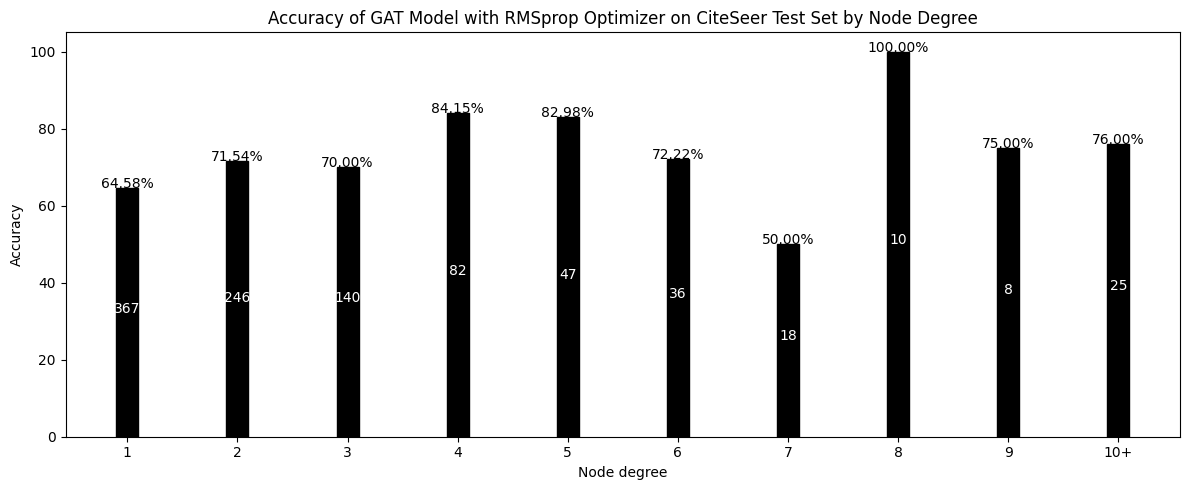

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return (sum(y_pred == y_true) / len(y_true))*100

# Get model's classifications
out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()
# Select degrees of nodes in test set
degrees=degrees[data.test_mask.numpy()]

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
pred = probas.argmax(dim=1)

# Test data
true_labels = data.y[data.test_mask].cpu().numpy()
predicted_labels = pred[data.test_mask].cpu().numpy()

# Accuracy for degrees between 0 and 5
for i in range(1, 10):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(predicted_labels[mask], true_labels[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 10
mask = np.where(degrees > 10)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy')
plt.bar(['1','2','3','4','5','6','7','8','9','10+'], accuracies, width=0.2, color='black', edgecolor='black')
for i in range(0, 10):
    plt.text(i, accuracies[i], f'{accuracies[i]:.2f}%', ha='center', color='black')
for i in range(0, 10):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

plt.title('Accuracy of GAT Model with RMSprop Optimizer on CiteSeer Test Set by Node Degree')
plt.tight_layout()
plt.savefig('GAT_CiteSeer_RMSprop_Accuracy_by_Degree.png')

plt.show()